# Part 1

## Step 1

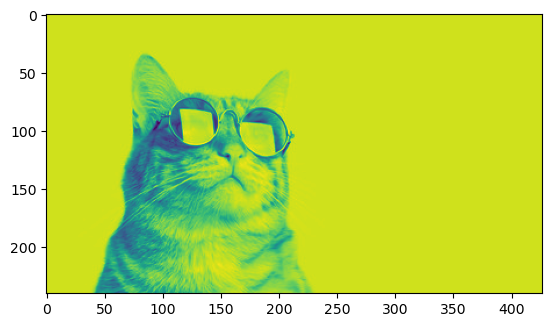

In [26]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image, ImageOps
from io import BytesIO

def download_and_grayscale(url):
    r = requests.get(url)
    b = r.content

    image = Image.open(BytesIO(b))
    grey = ImageOps.grayscale(image)
    return np.array(grey)

image = download_and_grayscale('https://t4.ftcdn.net/jpg/03/03/62/45/240_F_303624505_u0bFT1Rnoj8CMUSs8wMCwoKlnWlh5Jiq.jpg')
plt.imshow(image)

# Step 3:

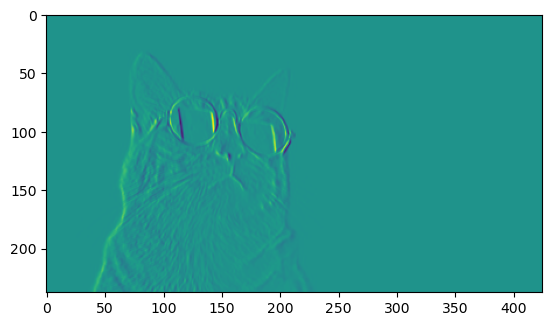

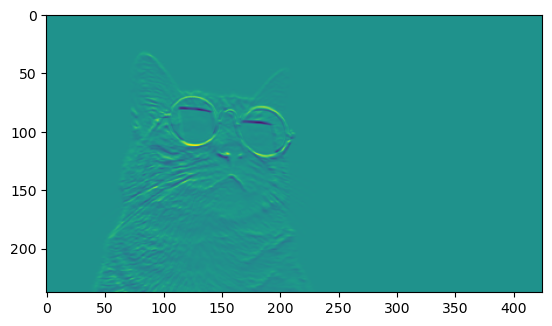

In [27]:

import torch
conv = torch.nn.Conv2d(1,2,3, bias=False)
conv.weight.data[0,0,:,:] = torch.tensor([[1,0,-1],[1,0,-1],[1,0,-1]])
conv.weight.data[1,0,:,:] = torch.tensor([[1,1,1],[0,0,0],[-1,-1,-1]])

out = conv(torch.tensor(image).unsqueeze(0).unsqueeze(0).float())
plt.imshow(out.detach()[0,0])
plt.show()
plt.imshow(out.detach()[0,1])


## Step 6

In [32]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.eval();

from PIL import Image
from torchvision import transforms
def download_image(url):
    r = requests.get(url)
    b = r.content

    image = Image.open(BytesIO(b))
    return image

input_image = download_image('https://t4.ftcdn.net/jpg/03/03/62/45/240_F_303624505_u0bFT1Rnoj8CMUSs8wMCwoKlnWlh5Jiq.jpg')
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

Using cache found in /Users/lukasheinrich/.cache/torch/hub/pytorch_vision_v0.10.0


In [33]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2023-03-30 13:44:18--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8000::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: 'imagenet_classes.txt.2'

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0.002s  

2023-03-30 13:44:18 (5.07 MB/s) - 'imagenet_classes.txt.2' saved [10472/10472]



In [34]:
with torch.no_grad():
    output = model(input_batch)

probabilities = torch.nn.functional.softmax(output[0], dim=0)
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())


sunglasses 0.2776077687740326
tabby 0.21239636838436127
tiger cat 0.11655237525701523
sunglass 0.10848134756088257
Egyptian cat 0.04756350442767143


# Part 2

## Step 1

In [35]:
!pip install mnist

In [36]:
import mnist
train_labels = mnist.train_labels()
test_labels = mnist.test_labels()
scale_mean, scale_std = mnist.train_images().mean(),mnist.train_images().std()
train_images = (mnist.train_images()-scale_mean)/scale_std
test_images = (mnist.test_images()-scale_mean)/scale_std

def make_batch(N = 300, collection = 'train'):
    images = train_images if collection == 'train' else test_images
    labels = train_labels if collection == 'train' else test_labels
        
    indices = np.random.choice(np.arange(len(images)), size = (N,), replace = True)
    X = images[indices]
    y = labels[indices]
    return torch.FloatTensor(X[:,None]),torch.LongTensor(y)


In [39]:
def create_cnn():
    return torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2),
        torch.nn.Flatten(),
        torch.nn.Linear(512,10),
)



In [53]:
def train(model, Nsteps = 1000):
    trajectory = []
    optim = torch.optim.Adam(model.parameters(),1e-3)
    for i in range(Nsteps):
        X,y = make_batch(N = 200, collection='train')
        p = model(X)
        loss = torch.nn.functional.cross_entropy(p,y)
        loss.backward()
        optim.step()
        optim.zero_grad()
        
        trajectory.append(float(loss))
        if i % 100 == 0:
            print(f'loss: {i}: {loss:.4f}')
    return model,np.array(trajectory)

In [56]:
model = create_cnn()
trained_model, traj = train(model)

loss: 0: 2.3058
loss: 100: 0.1764
loss: 200: 0.1927
loss: 300: 0.0893
loss: 400: 0.1078
loss: 500: 0.0986
loss: 600: 0.2053
loss: 700: 0.0665
loss: 800: 0.0841
loss: 900: 0.0448


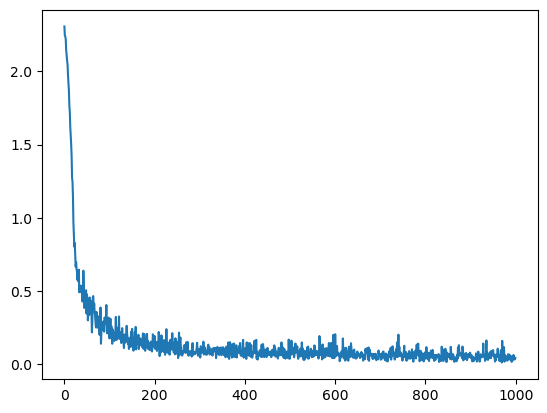

In [57]:
plt.plot(traj)

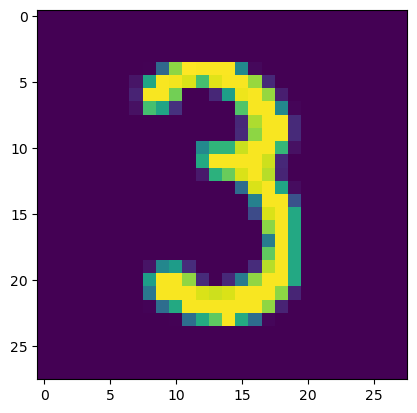

In [59]:
X,y = make_batch(N = 1, collection='test')
plt.imshow(X[0,0])

/var/folders/hn/y10jq2sn3cs3wnqv65l2rc040000gn/T/ipykernel_5763/1106651872.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.bar(range(10),torch.nn.functional.softmax(model(X)).detach()[0])


[]

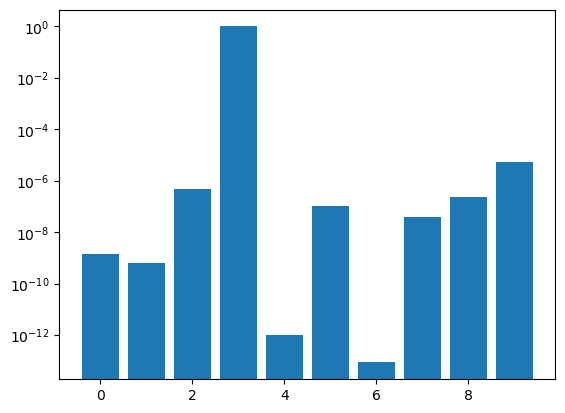

In [66]:
plt.bar(range(10),torch.nn.functional.softmax(model(X)).detach()[0])
plt.semilogy()